In [1]:
!pip install -r requirement.txt

In [2]:
import numpy as np
import geatpy as ea
import pandas as pd
import random
from datetime import datetime
import parser
print(ea.__version__)

debug = 1 # debug mode

2.7.0


### READ DATA
TODO: read data from GP

In [3]:
rawData = pd.read_excel(io='./FCI ANZ (2022-07-08) (NBV as at 30 Jun 2022)_v2.xlsx', sheet_name='Raw (portfolio)', engine='openpyxl')

In [4]:
# randomly choose 1000 samples
n = 10000
rawData = rawData.iloc[:30000, :61]

In [5]:
data = rawData.sample(n)
print(data.shape)
data.sample(3)

(10000, 61)


,Business Unit (Contract),Business Unit Am,Unit Id Fz,Cost,Po Num Fz,Mfr Dt Fz,Asset Id,Pool Fz,Product,Birth Unit Id Fz,...,Correct CEU,NP year,NBV check,age at drawdown X CEU,RML at drawdown X CEU,category,string,filter 2017 contracts,contract units,filter no. of units
4050,FZOPS,DF3RM,FDCU0045962,3682.0,DFIC-FL-1801,2/28/2018,1121280.0,DFC3,D4H,FDCU0045962,...,1.7,2018 NP,Reasonable,8.637164,15.886849,from ANZ portfolio,LT-MSC-35BD4H,NaN,5621.0,1.0
18586,FZOPS,DF3RM,FFAU4050851,6000.0,CSIH-FL-2115,4/12/2021,1707982.0,DFC3,D4H,FFAU4050851,...,1.7,2021 NP,Reasonable,3.350164,10.637808,from ANZ portfolio,LT-MSC-48D4H,NaN,6997.0,1.0
19839,FZOPS,DF3RM,FDCU0612562,3849.0,CIMC-FL-1804,4/6/2018,1212104.0,DFC3,D4H,FDCU0612562,...,1.7,2018 NP,Reasonable,8.467164,6.026849,from available portfolio,LE-ONE-01D4H,NaN,2539.0,1.0


### DATA PREPARATION

In [6]:
# TODO: add more columns later
input_data = \
    data.loc[:, ['Cost', 'Mfr Dt Fz', 'Product', 'Contract Cust Id', 'Contract Dt', 'Contract Expiration Dt', 'Nbv', 'Billing Status Fz']]
input_data.head(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
8433,3702.0,6/11/2018,D4H,MSC,2018-03-01,2032-07-31,2967.91,ON
27508,3682.0,1/1/2018,D4H,HAPAG,2017-11-01,2030-01-31,2869.54,ON
15442,6000.0,4/8/2021,D4H,MSC,2021-04-01,2029-06-30,5612.35,ON


#### Find standard equipment

Assign to `Product`

In [7]:
# select standard equipment
standardEquipment = ['D4H', 'D20', 'D40']
def SelectStandardEquip(Product):
    if Product in standardEquipment:
        Product = 1
    else:
        Product = 0
    return Product

input_data['Product'] = input_data.apply(lambda x: SelectStandardEquip(x['Product']), axis=1)
input_data.head(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
8433,3702.0,6/11/2018,1,MSC,2018-03-01,2032-07-31,2967.91,ON
27508,3682.0,1/1/2018,1,HAPAG,2017-11-01,2030-01-31,2869.54,ON
15442,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.35,ON


#### Find Top 1 and Top 3 Lessees

Assign new column `Top1Lessee` and `Top3Lessees`

In [8]:
# select the Top1 lessee
input_data.groupby('Contract Cust Id').count().sort_values('Cost', ascending=False)

,Cost,Mfr Dt Fz,Product,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz
Contract Cust Id,,,,,,,
MSC,4150,4150,4150,4150,4150,4150,4150
ONE,3669,3669,3669,3669,3669,3669,3669
HAPAG,1989,1989,1989,1989,1989,1989,1989
TCLC,72,72,72,72,72,72,72
CMA,45,45,45,45,45,45,45
COSMR,45,45,45,45,45,45,45
PANOCEAN,30,30,30,30,30,30,30


In [9]:
# top1 and top3 lessees 
Top1Lessee = 'MSC'
Top3Lessees = ['MSC', 'ONE', 'HAPAG']

In [10]:
def SelectTop1(custID):
    if custID == Top1Lessee:
        custID = 1
    else:
        custID = 0
    return custID

def SelectTop3(custID):
    if custID in Top3Lessees:
        custID = 1
    else:
        custID = 0
    return custID

input_data['Top1Lessee'] = input_data.apply(lambda x: SelectTop1(x['Contract Cust Id']), axis=1)
input_data['Top3Lessees'] = input_data.apply(lambda x: SelectTop3(x['Contract Cust Id']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees
19074,5150.0,5/21/2021,1,MSC,2021-04-01,2029-06-30,4801.46,ON,1,1
17297,6000.0,5/9/2021,1,MSC,2021-04-01,2029-06-30,5612.35,ON,1,1
12967,4420.0,2/23/2021,1,ONE,2020-11-16,2029-05-15,4117.43,ON,0,1


#### Calcualte manufacture age
Assign new column `MfrAge`

In [11]:
# TODO: consider timezone, consider time_now in the future
time_now = datetime.now()
# calculate manufacture age
date_format = '%m/%d/%Y'
# return in years, round to 2 decimal
def CalculateManufacutreAge(date):
    diff = time_now.date() - datetime.strptime(date, date_format).date()
    return round(diff.days / 365, 2)

input_data['MfrAge'] = input_data.apply(lambda x: CalculateManufacutreAge(x['Mfr Dt Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge
18787,5150.0,4/20/2021,1,MSC,2021-04-01,2029-06-30,4773.958,ON,1,1,1.44
5871,3682.0,1/1/2018,1,MSC,2018-03-01,2032-07-31,2933.000,ON,1,1,4.74
13900,6007.0,4/28/2021,1,MSC,2021-04-01,2029-06-30,5618.800,ON,1,1,1.42


#### Calculate unexpired year 
Assign new column `ExpYear`

In [12]:
# TODO: consider timezone, consider time_now in the future
# TODO: 'Contract Expiration Dt' is in Timestamp, the data type may change
time_now = datetime.now()
# calculate manufacture age
date_format = '%Y-%m-%d'
# return in years, round to 2 decimal
def CalculateExpYear(date):
    diff = pd.to_datetime(date,format="%Y%m%d").date() - time_now.date()
    return round(diff.days / 365, 2)

input_data['ExpYear'] = input_data.apply(lambda x: CalculateExpYear(x['Contract Expiration Dt']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
23762,2267.0,3/22/2018,1,ONE,2018-02-01,2026-10-14,1879.920,ON,0,1,4.52,4.05
1477,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.838,ON,0,1,4.78,7.35
8130,3702.0,6/11/2018,1,MSC,2018-03-01,2032-07-31,2967.910,ON,1,1,4.30,9.85


Select billing status

In [13]:
def SelectBilling(status):
    if status == 'ON':
        status = 1
    else:
        status = 0
    return status

input_data['Billing Status Fz'] = input_data.apply(lambda x: SelectBilling(x['Billing Status Fz']), axis=1)
input_data.sample(3)

,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
1358,3832.0,12/18/2017,1,HAPAG,2017-11-01,2030-01-31,2981.838,1,0,1,4.78,7.35
24898,2267.0,3/22/2018,1,ONE,2018-02-01,2026-10-14,1880.708,1,0,1,4.52,4.05
15599,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.350,1,1,1,1.47,6.76


Save data

In [14]:
input_data.to_csv('prepared_data.csv')

In [15]:
prepared_data = pd.read_csv('./prepared_data.csv')
prepared_data.head(3)

,Unnamed: 0,Cost,Mfr Dt Fz,Product,Contract Cust Id,Contract Dt,Contract Expiration Dt,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
0,8433,3702.0,6/11/2018,1,MSC,2018-03-01,2032-07-31,2967.91,1,1,1,4.30,9.85
1,27508,3682.0,1/1/2018,1,HAPAG,2017-11-01,2030-01-31,2869.54,1,0,1,4.74,7.35
2,15442,6000.0,4/8/2021,1,MSC,2021-04-01,2029-06-30,5612.35,1,1,1,1.47,6.76


### Model Part

#### Input

Convert pandas to numpy array

TODO: set input, may consider alt way.

In [16]:
prepared_data.describe()

,Unnamed: 0,Cost,Product,Nbv,Billing Status Fz,Top1Lessee,Top3Lessees,MfrAge,ExpYear
count,10000.000000,10000.000000,10000.0,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,15085.010100,3987.712968,1.0,3444.490614,1.0,0.415000,0.980800,3.516084,6.695183
std,8700.434422,1235.662553,0.0,1286.925122,0.0,0.492747,0.137234,1.493448,2.014760
min,0.000000,2182.000000,1.0,1784.484000,1.0,0.000000,0.000000,1.350000,1.010000
25%,7524.250000,3682.000000,1.0,2869.540000,1.0,0.000000,1.000000,1.510000,4.050000
50%,15150.500000,3832.000000,1.0,2981.834000,1.0,0.000000,1.000000,4.520000,6.760000
75%,22664.250000,4420.000000,1.0,4155.250000,1.0,1.000000,1.000000,4.730000,7.350000
max,29999.000000,7081.000000,1.0,6626.060000,1.0,1.000000,1.000000,4.840000,9.850000


In [17]:
cost = prepared_data['Cost'].to_numpy().reshape(n, 1)
nbv = prepared_data['Nbv'].to_numpy().reshape(n, 1)
product = prepared_data['Product'].to_numpy()
mfrAge = prepared_data['MfrAge'].to_numpy().reshape(n, 1)
lesseStatus = prepared_data['Billing Status Fz'].to_numpy()
expYear = prepared_data['ExpYear'].to_numpy().reshape(n, 1)
top1 = prepared_data['Top1Lessee'].to_numpy()
top3 = prepared_data['Top3Lessees'].to_numpy()

if debug:
    print('nbv shape: ', nbv.shape)
    print('product shape: ', product.shape)
    print('mfrAge shape: ', mfrAge.shape)
    print('lesseStatus shape: ', lesseStatus.shape)
    print('expYear shape: ', expYear.shape)


nbv shape:  (10000, 1)
product shape:  (10000,)
mfrAge shape:  (10000, 1)
lesseStatus shape:  (10000,)
expYear shape:  (10000, 1)


#### Constraints

`x`: np.array, size=num_of_container. `x[i]=1` stands for $i^{th}$ container is selected; `x[i]=0` stands for $i^{th}$ container is not selected.

1. NBV of standard equip >= 80%: `sum(x*Product*Nbv) / sum(x*Nbv) >= 0.8`

2. Avg age of equip <= 3.75: TODO

3. Avg age of Manufacturing < 7: `sum(x*MfrAge) / sum(x) <= 7`

4. Equipment port subject to lease >= 90%: TODO

5. Avg unexpired term under leases >= 5: `sum(x*Billing Status Fz*ExpYear) / sum(x*Billing Status Fz) >= 5`

6. Top 1 NBV <= 50%: `sum(x*Top1Lessee*Nbv) / sum(x*Nbv) <= 0.5`

7. Top 3 NBV <= 70%: `sum(x*Top3Lessee*Nbv) / sum(x*Nbv) <= 0.7`

#### Objective

min Cost: `min sum(x*Cost)`

#### Define Problem
Define objective function and constraint functions

In [82]:
def DEMO():
    class MyProblem(ea.Problem):
        def __init__(self):
            name ='MyProblem'
            M = 1
            maxormins = [1] # -1: max, 1: min
            Dim = n # num of variables
            varTypes = [1] * Dim # integers: 0 or 1
            lb = [0] * Dim # low bound
            ub = [1] * Dim # up bound
            lbin = [1] * Dim # low bound include
            ubin = [1] * Dim # up bound include
            ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb,ub, lbin, ubin)
            
        def aimFunc(self, pop):
            Vars = pop.Phen
            
            # two optimization methods are showed below. now we only care the first one.
            pop.ObjV = Vars @ cost

            pop.CV = np.hstack([
                -((Vars * product @ nbv) / (Vars @ nbv) - 0.8),
                (Vars @ mfrAge) / Vars.sum(axis=1, keepdims=True) - 7,
                -((Vars * lesseStatus @ expYear) / (Vars * lesseStatus).sum(axis=1, keepdims=True) - 5),
                (Vars * top1 @ nbv) / (Vars @ nbv) - 0.5,
#                 (Vars * top3 @ nbv) / (Vars @ nbv) - 0.7
            ])




    problem = MyProblem()
    Encoding ='RI'
    NIND = 100 # init number of population instance
    Field = ea.crtfld(Encoding, problem.varTypes, problem.ranges,problem.borders)
    population = ea.Population(Encoding, Field, NIND)

    # set parameters
    myAlgorithm = ea.soea_DE_best_1_L_templet(problem, population)
    myAlgorithm.MAXGEN = 10000
    myAlgorithm.mutOper.F = 0.5
    myAlgorithm.recOper.XOVR = 0.7
    myAlgorithm.logTras = 1
    myAlgorithm.trappedValue = 1e-6
#     myAlgorithm.maxTrappedCount = 100

    # TODO: random seed has a significant influence on final result!
    # outputMsg=True to show the result
    res = ea.optimize(myAlgorithm, seed=2049, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    if debug:
        print(res)
    return res

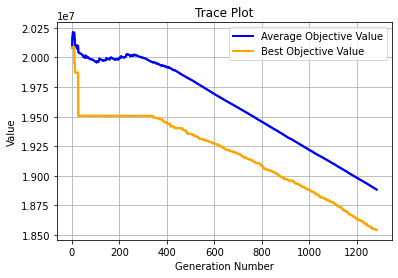

Execution time: 105.35420870780945 s
Evaluation number: 157300
The best objective value is: 18543612.740000002
The best variables are: 


0	1	0	0	1	0	0	1	0	1	0	0	1	0	0	0	1	1	1	1	1	1	0	0	0	0	1	0	0	0	1	1	0	1	0	1	1	0	0	1	0	1	1	1	0	1	0	1	0	0	1	1	1	0	0	0	0	0	0	1	0	0	0	0	1	0	0	0	1	0	1	1	0	0	1	0	0	0	0	0	0	0	0	0	0	0	0	1	0	1	0	0	1	0	1	1	1	1	1	0	0	1	0	0	0	1	0	1	1	0	1	0	0	1	0	1	0	1	0	1	0	1	1	0	1	1	1	0	0	1	1	0	0	1	0	0	1	1	1	0	1	0	0	0	0	0	1	1	1	1	0	0	0	0	0	0	1	0	0	0	1	0	1	1	0	0	1	0	1	1	1	1	0	1	1	1	1	0	0	0	0	1	0	1	0	1	0	0	0	0	1	1	1	1	0	1	1	0	0	1	0	1	0	0	1	0	1	0	1	0	1	1	0	0	1	0	1	0	0	1	0	0	0	1	1	1	0	0	0	1	0	0	0	1	1	0	1	0	0	1	1	1	1	0	0	0	0	1	0	1	0	1	0	1	1	0	1	0	1	1	1	0	0	0	1	1	0	0	0	1	0	1	0	1	1	0	1	1	0	0	0	0	1	0	0	1	0	1	1	1	1	1	1	0	1	1	1	0	1	0	1	0	0	0	0	1	1	1	0	1	0	0	0	0	1	0	1	1	0	1	1	0	0	1	0	0	0	0	0	0	1	0	1	1	0	1	0	1	1	1	1	0	1	0	1	1	0	1	1	0	0	0	0	0	1	0	0	1	0	0	0	1	0	1	0	1	1	0	0	1	1	1	1	0	1	1	1	0	1	0	1	1	1	1	0	0	1	1	1	1	1	1	0	0	1	0	1	1	0	0	0	0	0	0	0	1	0	0	0	1	1	1	0	1	1	1	1	0	0	1	0	0	0	1	0	0	0	0	1	1	0	0	1	0	1	0	0	1	1	0	0	1	1	0	0	0	1	0	1	1	0	1	0	0	1	1	0	1	1	0	0	0	1	0	1	1	0	1	0	1	1	1	1	1	0	1	1	1	1	0	0	1	1	0	1	0	1	0	0	0	0	1	1	0	1	0	0	1	0	0	

	1	0	0	1	1	1	1	0	1	1	0	0	0	1	0	0	1	1	0	0	1	0	1	1	0	0	1	1	0	1	0	1	0	1	1	1	0	0	0	0	0	0	1	0	1	1	1	1	0	1	1	0	1	0	1	0	0	1	1	0	0	0	0	1	1	0	0	1	1	1	1	1	1	0	0	1	0	1	0	1	1	0	1	1	1	1	1	1	1	0	0	0	0	1	0	0	1	1	0	1	0	1	0	1	0	0	0	0	1	0	0	1	1	0	0	0	0	1	0	1	1	0	1	0	0	0	0	0	0	1	1	0	0	1	1	0	0	1	1	0	0	0	0	1	1	0	1	0	1	0	1	0	0	0	0	1	1	0	0	0	0	1	0	1	1	1	0	1	1	1	1	1	0	0	0	0	0	0	0	1	0	0	0	1	1	0	0	0	1	0	1	0	0	0	1	1	0	1	1	1	1	0	0	1	1	0	1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	0	0	1	0	1	1	0	1	0	1	0	1	0	0	1	0	1	1	1	1	1	0	0	0	0	0	1	0	0	1	1	0	1	1	1	1	0	1	0	1	1	1	0	1	0	0	0	1	0	1	1	0	1	0	0	0	0	0	1	1	1	0	1	1	1	0	0	0	1	1	0	0	1	0	0	1	0	0	1	1	1	1	1	0	0	1	1	1	0	1	1	1	1	0	0	1	0	0	1	0	1	1	0	0	1	0	0	0	0	1	1	0	0	0	1	1	0	0	0	0	0	0	0	1	0	1	1	1	1	1	0	1	0	0	0	0	1	0	0	1	0	1	0	0	1	0	0	1	0	0	1	1	0	0	0	0	0	0	0	0	1	0	1	0	0	0	0	1	1	0	0	1	0	0	1	1	0	0	1	0	0	0	1	1	1	1	0	1	0	0	1	1	1	0	1	0	0	0	1	1	0	1	0	0	1	0	0	0	0	0	0	1	0	0	1	1	0	0	1	0	0	1	0	0	1	0	0	0	0	1	1	0	1	0	1	1	0	0	1	1	0	0	1	1	0	0	0	0	1	0	1	0	1	1	1	1	1	1	1	0	1	1	1	1	0	0	1	1	0	0	1	1	1	1	0	1	0	1	0

In [83]:
# 100, 1e-6, 1000
selectedPackage = DEMO()

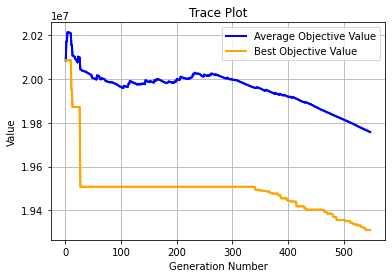

Execution time: 50.0774450302124 s
Evaluation number: 83600
The best objective value is: 19310923.0
The best variables are: 


1	0	0	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	0	1	1	0	0	1	0	0	0	0	0	0	1	1	0	1	0	1	0	0	1	0	0	0	1	0	1	1	1	1	0	0	0	0	1	1	1	1	1	0	1	1	0	0	1	1	0	0	1	1	0	0	0	1	1	1	1	0	1	1	0	0	1	0	0	0	0	0	1	0	0	1	1	1	0	0	0	0	0	1	1	1	0	1	1	0	0	0	0	0	1	0	0	0	1	1	1	1	1	1	1	1	1	1	1	1	1	0	0	0	0	1	1	0	0	0	1	1	0	1	0	0	0	1	1	1	0	0	0	0	1	0	1	0	1	1	0	0	1	0	1	1	1	0	0	0	1	1	0	0	1	1	0	0	0	1	1	0	0	0	1	1	0	0	0	1	1	0	0	1	0	1	0	1	1	1	0	1	1	0	0	1	1	0	1	0	0	0	1	0	0	0	0	0	1	0	0	0	0	0	0	1	1	1	1	0	0	1	0	1	1	0	0	1	0	1	1	1	0	0	1	0	1	1	1	0	0	1	1	0	1	1	1	1	0	1	0	1	0	0	0	0	0	1	1	1	1	0	0	1	1	0	1	0	0	0	1	0	0	0	0	0	1	0	1	0	1	1	1	1	0	0	1	0	1	1	0	0	0	1	1	1	1	1	0	0	0	1	0	0	1	0	1	1	1	0	0	1	0	1	0	0	0	0	1	1	1	1	0	1	0	0	1	0	1	1	0	0	1	1	0	1	0	0	1	0	1	1	1	1	1	1	0	0	1	0	1	1	0	1	1	0	1	1	1	1	1	1	1	0	0	0	1	1	0	1	1	1	1	0	1	0	0	0	0	0	0	0	0	0	1	0	1	1	1	0	1	0	0	0	0	1	1	0	0	1	0	1	0	1	0	0	1	0	0	0	0	1	0	1	1	0	1	1	0	0	1	1	0	0	0	1	1	1	0	0	1	0	1	1	1	0	1	1	1	0	0	1	1	0	1	1	0	0	0	0	1	0	1	1	0	1	1	0	1	1	1	1	0	1	1	0	0	1	0	1	1	0	0	0	0	1	0	0	0	0	1	1	0	1	0	1	1	0	0	0	0	0	0	

1	0	0	1	0	1	1	1	1	1	1	1	1	1	0	1	0	1	0	1	1	1	0	1	0	0	1	0	0	1	1	1	1	1	1	1	1	0	0	1	0	0	1	0	0	0	1	1	1	0	0	0	0	1	1	1	0	0	0	1	1	1	1	0	1	1	0	0	1	0	1	0	1	0	1	0	1	1	1	1	1	1	1	1	0	1	1	0	1	1	0	0	0	1	1	1	0	1	0	0	1	0	0	1	0	0	1	1	0	1	1	1	1	0	1	0	1	0	0	1	1	0	1	0	0	0	0	1	0	0	1	0	0	0	1	1	0	1	1	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	1	1	0	1	0	0	0	0	1	1	1	0	0	0	1	0	0	0	0	1	1	0	1	1	0	0	0	1	1	1	1	0	1	1	1	1	0	0	1	1	0	0	0	0	1	0	1	1	1	1	0	0	1	0	0	0	0	1	1	1	0	1	0	1	0	0	0	0	1	0	0	1	1	1	1	0	0	0	0	0	1	0	0	0	1	1	0	1	0	0	0	0	1	1	1	0	0	1	1	0	1	1	0	1	1	1	1	1	0	0	1	0	0	0	1	0	1	1	1	0	0	0	0	0	1	1	0	1	1	1	0	0	1	0	0	0	0	1	0	0	0	0	1	0	0	0	1	0	0	0	0	1	0	1	1	0	0	1	1	1	1	1	0	0	1	0	1	1	0	0	0	0	0	1	1	0	0	1	1	1	1	1	0	0	0	1	0	1	1	0	1	1	0	0	0	0	0	0	1	1	0	0	0	0	1	0	1	0	1	0	1	1	0	1	1	0	0	1	0	1	1	1	1	0	1	0	0	0	0	0	0	1	0	1	0	0	1	1	0	1	0	1	0	0	1	0	1	0	0	0	1	1	0	0	1	0	0	0	1	1	1	1	0	1	0	0	1	0	0	0	0	1	0	1	1	0	0	1	1	0	1	1	0	0	1	0	0	0	1	1	0	0	0	0	1	1	1	1	0	0	0	1	1	0	1	0	0	1	0	1	0	0	1	1	0	0	1	0	1	0	1	0	1	0	0	0	0	0	0	1	1	0	0	1	0	0	0	1	1	0	0	0	1	1	1	

In [79]:
# 100, 1e-6, 500
selectedPackage = DEMO()

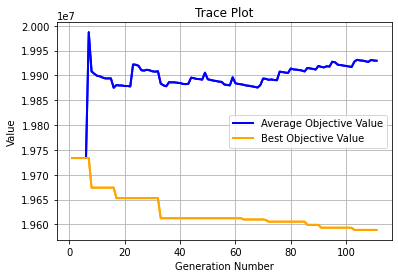

Execution time: 106.08935070037842 s
Evaluation number: 165500
The best objective value is: 19588729.82
The best variables are: 


0	1	1	1	0	1	1	0	1	1	1	0	1	0	0	1	1	1	0	1	1	1	1	1	0	1	0	1	0	0	1	1	1	0	1	0	0	0	1	1	0	1	1	0	1	0	1	1	0	0	0	1	1	0	1	0	1	1	1	0	1	0	1	1	1	1	0	0	1	1	1	0	0	1	0	0	0	0	0	0	0	1	1	1	1	0	0	0	0	1	0	1	0	0	1	1	1	0	1	1	0	1	0	1	1	0	0	1	0	0	1	1	1	1	1	0	0	1	1	0	0	1	0	0	0	0	0	0	0	1	1	0	0	1	1	0	0	1	1	1	1	1	0	1	0	1	1	1	0	0	1	1	0	1	0	0	1	0	0	0	1	0	0	0	0	0	0	0	1	1	1	1	1	1	0	0	1	0	1	1	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	1	0	0	1	0	0	1	0	0	0	1	1	1	1	0	0	0	0	1	0	0	0	0	1	0	1	1	1	1	0	0	1	1	0	0	1	0	1	0	1	1	1	0	1	1	0	1	1	1	1	0	0	1	0	1	1	0	1	0	0	1	0	1	0	1	1	0	0	1	0	1	0	0	0	0	1	1	0	0	0	1	1	1	0	1	1	1	0	0	0	0	0	0	0	0	0	1	1	0	0	1	0	1	1	1	1	1	1	0	0	0	1	1	1	1	1	0	1	1	1	0	0	1	0	0	0	1	0	1	1	1	1	1	0	0	0	0	0	1	0	0	0	0	1	0	1	0	1	1	0	0	1	0	1	0	1	1	1	0	0	1	1	0	1	1	0	0	0	1	0	1	1	0	1	0	0	0	0	1	1	0	1	0	1	1	1	1	0	1	1	1	1	0	1	1	0	0	1	1	1	1	0	1	1	1	1	0	1	0	1	0	1	1	1	1	0	1	0	0	0	0	0	0	0	0	1	1	1	0	0	1	0	1	0	0	1	1	0	0	0	1	1	1	0	0	0	1	1	0	0	0	0	0	0	1	1	0	1	0	1	1	1	1	0	1	1	0	1	0	0	1	1	0	0	0	0	1	1	0	0	1	1	0	0	0	0	1	0	1	0	1	1	1	1	0	1	1	0	1	1	1	0	

	0	0	1	0	1	0	1	0	1	1	1	0	0	1	1	0	1	0	0	0	0	1	0	0	1	0	0	0	0	0	1	1	1	1	0	1	1	1	0	1	1	0	1	1	0	1	0	0	0	0	0	0	0	1	1	1	1	1	1	0	0	1	1	1	0	0	1	1	0	1	0	1	1	0	0	1	0	0	1	0	1	1	1	1	0	0	1	0	0	1	0	0	1	1	0	1	1	1	0	1	1	1	0	0	1	1	0	0	0	1	0	1	1	1	0	0	0	1	1	0	1	1	1	0	1	0	1	1	0	0	1	1	0	0	1	0	1	0	0	0	1	0	0	1	0	1	0	1	1	1	0	0	0	1	0	0	0	0	1	0	1	0	0	1	0	0	0	0	0	1	0	0	1	0	1	0	1	0	1	0	1	1	0	0	1	0	0	0	1	1	1	0	0	1	0	0	1	0	0	1	0	0	1	0	1	1	0	0	1	1	0	1	1	1	1	1	1	0	1	0	0	0	1	0	1	0	0	0	0	0	1	1	1	0	1	0	1	0	1	1	0	0	0	0	1	0	1	1	0	1	0	0	0	1	0	1	1	1	0	0	1	1	1	1	0	1	0	0	0	1	1	0	0	0	1	1	0	0	0	1	0	1	1	0	0	0	1	0	1	0	1	1	1	1	0	0	1	0	1	1	0	1	0	0	1	0	0	0	1	1	1	1	0	0	0	1	1	0	0	0	0	1	1	0	0	0	0	0	1	0	1	1	1	1	0	0	0	0	1	0	0	0	0	1	1	0	0	0	0	1	0	0	0	0	0	1	0	1	0	1	1	1	1	0	0	1	1	1	0	0	1	0	1	1	0	0	1	0	0	0	0	1	0	1	1	1	1	1	0	1	1	1	0	0	0	1	0	0	0	0	1	0	1	0	1	1	0	1	0	1	1	0	0	0	1	1	1	1	1	1	0	0	1	0	1	0	0	1	0	1	0	1	1	0	0	1	0	0	0	0	0	0	1	0	0	1	1	1	0	1	1	0	0	1	1	1	0	1	1	1	1	1	0	0	1	1	1	1	0	0	0	0	0	0	0	1	1	0	1	0	1	1	0	1	0	0	1	1	1	0	0	1	0	1	1	0	0	1	0	0

In [81]:
# 500, 1e-6, 100
selectedPackage = DEMO()

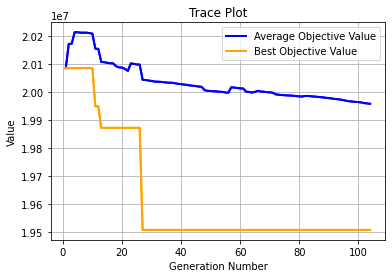

Execution time: 20.499690771102905 s
Evaluation number: 39300
The best objective value is: 19507745.880000003
The best variables are: 


1	0	1	0	1	1	0	0	0	1	1	1	0	0	0	0	1	0	1	0	1	1	0	0	0	1	1	0	0	1	0	0	1	0	0	1	1	0	0	1	0	1	1	1	0	1	1	1	0	1	0	1	0	0	0	0	0	0	0	0	1	1	1	1	1	1	1	0	0	1	0	0	0	0	0	0	1	1	0	1	0	0	1	1	0	0	0	0	0	0	1	0	1	1	1	1	0	1	1	0	0	0	1	0	0	1	1	0	1	1	0	0	0	1	0	1	0	0	1	0	1	1	1	0	1	0	0	1	1	1	0	0	0	1	1	1	1	0	1	1	0	1	0	0	1	0	1	1	0	1	0	1	1	1	0	0	0	0	0	0	0	0	0	1	0	1	0	0	0	1	0	0	1	0	1	1	1	1	1	0	1	1	1	1	1	0	0	1	1	0	1	0	1	0	1	1	1	0	0	1	0	1	0	1	1	1	1	0	1	0	0	0	1	1	0	0	0	0	0	1	1	0	0	1	0	0	0	0	0	0	1	0	1	0	0	0	0	1	0	1	1	0	0	1	0	1	0	1	1	1	1	0	1	1	1	0	1	1	0	0	0	0	1	1	0	1	0	0	1	1	0	1	0	1	0	0	0	1	0	0	0	1	0	1	0	1	1	0	1	0	1	1	0	0	1	1	1	0	0	1	0	1	0	1	0	0	0	0	0	0	0	0	0	1	0	1	1	0	0	1	0	1	0	1	1	0	0	1	0	0	0	0	1	0	1	1	1	0	0	1	1	0	1	1	0	0	0	0	0	0	1	1	1	0	0	1	0	0	1	0	0	0	1	1	1	0	1	0	1	1	0	0	0	0	1	0	0	0	0	0	0	1	1	0	1	1	0	1	0	0	0	0	1	1	1	1	1	0	0	0	1	1	0	1	1	0	0	0	1	1	0	1	0	1	1	0	1	0	0	1	0	1	0	0	0	1	0	1	1	1	1	0	0	0	0	1	0	0	1	1	1	1	1	0	1	1	0	0	1	0	0	0	1	0	0	0	0	0	0	1	1	1	0	1	0	0	1	0	0	0	0	0	1	1	0	1	0	0	1	0	0	0	0	0	1	0	0	1	1	0	1	1	0	1	0	0	1	0	1	0	

	1	0	1	1	1	1	1	1	0	0	1	1	0	0	1	0	0	1	1	0	0	0	0	0	1	0	0	1	0	0	0	1	0	0	1	0	1	1	1	0	1	1	1	0	1	0	1	0	0	1	0	0	1	1	1	1	1	1	1	0	0	1	0	1	1	1	1	1	0	1	1	0	1	0	1	1	1	0	1	1	0	1	0	0	0	1	1	0	1	1	0	0	0	0	1	0	0	1	1	0	1	1	1	0	1	1	1	1	1	0	0	1	0	1	0	1	0	1	1	0	0	0	0	1	1	1	1	1	0	1	0	1	0	1	0	0	1	1	1	0	0	0	0	0	1	0	1	1	0	1	0	0	0	0	0	1	0	0	0	1	0	0	1	0	1	1	1	1	0	0	1	1	0	0	1	0	0	1	0	0	1	1	0	1	1	1	0	1	0	1	0	0	1	1	0	1	0	0	1	1	0	1	0	1	1	0	1	0	1	0	0	0	0	0	0	1	1	0	0	1	1	0	0	1	1	1	1	0	1	0	0	0	1	0	0	1	0	1	1	1	0	0	0	0	0	0	1	0	1	1	0	0	0	0	0	1	1	0	0	0	1	1	0	1	0	0	1	0	0	1	0	0	1	0	1	1	1	0	0	0	0	0	1	0	0	0	0	1	0	1	0	1	0	1	1	0	0	0	0	0	1	0	0	0	1	1	0	1	0	0	1	1	0	1	1	1	1	0	0	1	1	0	1	1	1	0	1	0	0	0	0	1	1	0	0	1	0	1	0	1	1	1	1	1	1	1	1	1	1	0	0	0	0	0	1	0	0	1	1	1	1	0	0	0	0	1	0	1	1	1	0	0	1	1	0	0	0	0	0	0	0	1	0	0	1	1	1	1	0	0	1	0	1	1	0	1	0	0	1	0	0	1	1	0	1	0	0	1	0	1	0	0	0	0	1	0	0	0	0	0	1	1	0	1	1	1	0	1	1	1	0	0	0	0	0	1	0	1	1	1	0	1	1	1	0	1	0	0	0	0	1	0	1	0	1	0	1	1	0	1	0	1	1	1	0	0	1	0	1	1	0	0	1	1	0	1	1	0	0	1	1	1	1	0	1	1	1	0	0	0	1	1	0	1	1	0	1	0	1	1

In [77]:
# 100, 1e-6, 100
selectedPackage = DEMO()

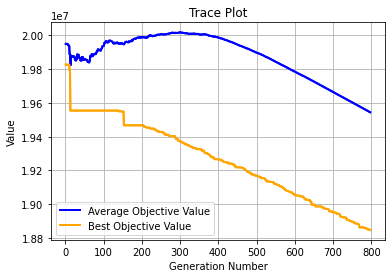

Execution time: 830.2958543300629 s
Evaluation number: 1000000
The best objective value is: 18848045.619999997
The best variables are: 


0	1	0	1	1	1	0	1	0	1	1	0	1	0	0	1	1	1	0	1	1	1	1	1	0	1	0	1	0	0	1	1	1	0	1	0	0	0	1	1	0	1	1	0	1	0	1	1	0	0	0	1	1	0	1	0	1	1	1	0	1	0	1	1	1	1	0	0	1	1	1	0	0	1	0	0	0	0	0	0	0	1	1	1	1	0	0	0	0	0	1	1	1	0	0	1	0	1	0	1	0	1	0	1	1	0	0	1	0	0	1	1	1	1	1	0	0	1	1	0	0	1	0	0	0	0	0	1	0	1	1	0	0	1	1	0	0	1	1	1	1	1	0	0	1	0	1	1	0	0	1	1	0	1	0	0	1	0	0	0	1	0	0	0	0	0	0	0	1	0	1	1	1	1	0	0	1	0	1	1	0	0	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	1	0	0	1	0	0	1	0	0	0	1	1	1	1	0	0	0	0	1	0	1	1	1	1	0	1	1	1	1	0	0	1	1	0	0	1	0	1	0	1	1	1	0	1	1	0	1	1	1	1	0	0	1	0	1	1	0	1	0	0	1	0	1	0	1	1	0	0	1	0	1	0	0	0	0	1	1	0	0	0	1	1	1	0	1	1	1	0	0	0	0	0	0	0	0	0	1	1	0	0	1	0	1	0	1	1	1	1	0	0	0	0	1	0	1	0	1	1	1	1	0	0	1	0	0	0	1	0	1	1	1	1	1	0	0	0	0	0	1	0	0	0	0	1	0	0	0	1	0	0	1	0	1	1	1	1	1	0	0	1	1	0	0	1	1	0	0	0	1	0	1	1	1	1	0	0	1	0	1	1	0	1	1	0	1	1	1	0	1	0	0	1	1	1	1	0	0	1	1	1	1	0	1	1	1	1	0	1	0	1	0	1	1	1	1	0	1	0	0	0	0	0	0	0	0	1	1	1	0	0	1	0	1	0	0	1	1	0	0	0	0	1	1	1	0	1	0	1	0	0	0	0	0	0	1	1	0	1	0	1	0	0	1	0	1	1	0	1	0	0	1	1	0	0	0	0	1	1	0	0	1	1	0	0	0	0	1	0	1	0	1	1	1	1	0	1	1	0	1	1	1	0	

1	0	0	1	1	1	0	0	0	1	0	0	1	0	1	0	1	0	1	1	0	0	0	1	1	0	1	0	0	0	0	1	0	0	1	0	0	0	0	0	1	1	1	1	0	1	1	1	0	1	1	0	1	0	1	1	1	1	1	0	0	0	0	1	1	1	1	1	1	0	0	1	1	1	0	0	1	1	0	1	0	1	1	0	1	1	0	0	1	0	1	1	1	1	0	0	0	0	0	1	0	0	1	0	0	1	1	0	1	0	0	1	1	0	1	1	0	0	0	1	0	1	0	0	0	0	0	0	0	0	1	1	1	1	1	0	1	1	0	0	1	0	0	0	0	0	1	0	0	0	1	0	0	1	0	1	0	1	0	1	0	0	0	1	0	0	0	0	1	0	1	0	1	0	0	0	0	0	0	0	0	0	1	0	1	0	1	0	1	0	1	1	0	0	1	0	0	0	1	1	0	0	0	1	0	0	1	0	0	1	0	0	1	0	1	0	1	0	1	0	1	0	0	1	1	0	1	0	1	0	0	0	1	0	1	0	0	0	1	0	1	1	1	0	1	0	1	0	1	1	0	0	0	0	1	0	1	1	0	1	0	0	0	1	0	1	1	1	0	0	1	1	1	1	0	1	0	0	0	1	1	0	0	0	0	1	1	0	0	1	0	1	1	0	0	0	1	0	1	0	1	1	1	1	0	0	1	0	1	1	0	1	0	0	1	0	0	0	1	1	1	1	0	0	0	1	1	0	0	0	0	1	1	0	0	0	0	0	1	0	1	1	1	1	0	0	0	0	1	0	0	0	0	1	1	0	0	1	1	1	1	0	1	0	0	1	0	1	0	1	1	1	1	0	0	1	1	1	0	0	1	0	1	0	0	1	1	0	0	0	0	1	0	1	1	1	1	1	0	1	1	1	0	0	0	1	0	0	0	0	0	0	1	0	1	1	0	1	0	1	1	0	0	0	1	1	1	1	1	1	0	0	1	0	1	0	0	1	1	1	0	1	1	0	0	1	0	0	0	0	0	0	1	0	0	1	1	0	0	1	1	0	0	1	1	1	0	1	1	1	1	1	0	0	1	1	1	1	0	0	0	0	0	0	0	1	1	0	1	0	1	1	0	1	0	0	1	1	1	0	

0	1	1	1	0	0	1	1	1	0	1	0	1	1	0	1	1	0	0	1	
{'success': True, 'stopMsg': 'The algotirhm stepped because it exceeded the generation limit.', 'optPop': <geatpy.Population.Population object at 0x7fcea496f240>, 'lastPop': <geatpy.Population.Population object at 0x7fcea496f780>, 'Vars': array([[0, 1, 0, ..., 0, 0, 1]], dtype=int32), 'ObjV': array([[18848045.62]]), 'CV': array([[-0.2       , -3.43860358, -1.625396  , -0.00474   ]]), 'executeTime': 830.2958543300629, 'nfev': 1000000, 'startTime': '2022-09-27 17h-06m-17s', 'endTime': '2022-09-27 17h-20m-10s'}


In [75]:
# 1000, 1e-6, 1000
selectedPackage = DEMO()

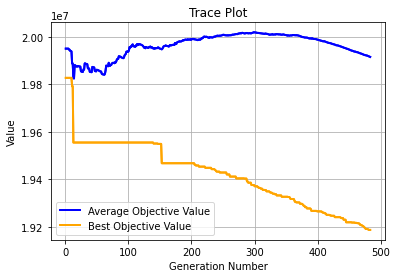

Execution time: 558.1470761299133 s
Evaluation number: 686000
The best objective value is: 19187073.52
The best variables are: 


1	1	0	0	0	1	1	1	0	1	0	0	1	0	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	1	0	1	0	1	1	1	0	0	0	1	1	1	1	0	0	0	1	1	0	0	1	0	1	1	1	1	1	0	1	0	1	1	0	0	0	0	0	1	1	1	0	0	1	0	0	0	0	1	1	1	0	0	1	1	0	1	0	0	1	0	0	1	1	0	1	0	0	1	1	1	0	0	0	1	0	0	0	0	0	1	1	0	1	1	0	0	0	0	0	1	1	0	0	1	1	0	1	0	1	0	1	0	1	1	0	0	1	1	0	1	1	0	0	0	0	0	1	0	1	0	0	0	0	1	0	0	1	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	0	1	1	0	0	0	1	1	0	0	0	1	1	1	0	1	0	0	1	1	0	0	1	0	0	1	0	0	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	0	1	1	1	1	0	0	0	1	1	0	1	0	1	0	0	1	0	0	0	1	0	0	1	0	1	1	0	0	0	0	1	1	0	0	1	0	1	0	0	1	0	1	1	1	0	1	1	0	0	1	0	1	1	0	1	1	0	0	0	0	1	1	0	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	0	0	1	1	1	0	1	1	1	1	0	0	0	1	0	0	0	1	1	0	1	0	1	1	0	0	0	0	0	1	1	0	1	1	0	1	0	1	0	1	1	0	1	1	0	1	0	1	1	1	1	0	1	1	0	0	1	0	0	1	1	0	0	0	1	1	0	0	0	0	1	1	1	1	1	1	1	0	0	0	1	0	1	1	1	1	0	1	0	0	1	1	0	1	0	0	1	1	0	0	0	0	1	0	1	1	0	0	1	1	1	1	1	1	1	1	0	1	1	0	0	0	0	1	1	1	1	0	1	0	0	1	1	1	1	1	1	0	0	0	1	0	0	1	1	1	0	1	0	1	1	1	0	1	0	1	0	0	0	1	1	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	1	1	0	0	0	0	0	1	0	0	0	0	1	1	1	0	1	1	1	0	0	1	0	1	0	

1	0	1	1	1	0	1	0	0	0	1	0	1	1	1	0	0	0	1	1	0	0	1	1	0	0	0	0	0	1	1	1	1	0	0	0	1	0	0	0	0	0	0	1	1	0	1	0	0	0	0	0	1	1	0	0	1	0	1	0	1	0	1	1	0	0	1	0	1	0	0	1	0	1	1	0	1	0	0	0	1	0	0	1	1	0	1	1	0	1	1	0	1	1	1	0	1	1	1	1	1	1	0	1	1	0	1	1	0	0	1	0	1	1	1	0	0	1	0	0	1	0	1	1	0	0	1	0	1	0	0	0	0	0	1	0	0	1	1	1	1	0	1	0	0	1	1	0	0	0	1	1	0	0	0	0	1	0	1	0	1	0	1	1	0	1	0	1	0	1	0	0	0	1	0	0	0	1	1	1	1	1	0	0	1	1	1	0	1	0	1	1	1	1	0	1	0	0	0	0	1	1	1	1	0	1	0	1	1	0	0	1	1	1	1	0	0	1	1	0	1	0	1	0	0	0	0	0	0	1	0	0	1	0	1	1	0	0	1	1	0	0	0	0	1	0	0	1	1	0	1	1	1	1	0	1	1	0	0	0	0	0	0	1	1	0	1	1	0	1	0	1	1	1	1	0	1	0	1	0	1	1	1	0	0	0	0	0	1	0	0	1	1	0	1	0	0	1	0	0	0	0	0	1	0	0	0	1	1	0	0	0	1	1	0	0	1	1	0	1	0	0	0	1	1	0	0	0	1	0	1	0	1	0	0	1	0	1	0	1	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	1	1	0	0	0	1	0	0	1	1	0	1	0	0	1	0	1	1	1	0	1	0	0	0	0	0	0	1	1	0	0	0	0	1	1	0	0	0	1	1	1	1	1	1	0	0	0	0	1	1	0	0	0	1	0	1	1	0	0	1	1	1	1	0	1	1	0	0	1	1	0	0	1	1	0	0	1	1	0	1	1	1	1	1	0	1	0	0	1	1	1	0	0	1	0	1	0	0	1	1	0	1	0	1	1	1	1	0	0	0	1	1	1	1	0	0	0	1	1	1	1	0	0	0	0	0	1	1	1	0	0	0	0	1	1	1	0	1	0	0	

1	1	0	0	1	1	1	0	1	0	0	1	0	0	0	1	0	1	0	0	0	0	0	1	0	0	1	0	0	1	1	0	0	1	1	0	1	0	1	0	0	0	1	1	0	1	0	1	0	1	1	0	1	1	1	0	0	1	1	0	1	0	0	1	0	1	0	0	0	1	0	0	0	1	1	1	0	1	0	0	0	1	1	0	1	1	0	0	1	1	1	0	0	0	0	1	1	0	1	1	1	1	0	0	1	1	1	1	1	0	0	0	0	1	0	1	1	1	1	0	0	0	1	1	0	0	0	0	0	1	0	0	1	0	0	0	0	0	0	1	1	0	0	1	0	0	1	1	1	0	1	0	1	1	0	0	0	0	1	1	1	1	1	1	0	0	1	1	1	1	0	0	0	1	0	0	1	1	1	1	0	1	0	1	1	0	0	1	0	1	0	0	1	0	0	0	0	0	1	0	1	0	0	0	1	0	0	1	0	0	0	0	1	1	1	0	1	1	1	0	0	0	0	1	1	1	0	0	1	1	0	1	0	1	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	1	1	0	0	1	0	1	1	0	1	0	0	0	0	1	1	0	1	1	1	1	1	0	1	1	0	1	0	1	0	0	0	0	1	0	1	0	1	1	1	1	0	0	1	0	1	1	1	1	1	1	0	0	1	1	1	0	1	0	1	0	1	0	0	0	0	0	1	0	1	0	0	1	0	0	0	1	0	0	0	1	1	1	1	1	1	1	0	1	1	1	1	0	0	0	1	1	0	0	0	0	0	1	0	0	1	1	0	0	1	1	1	1	0	1	1	0	1	1	1	0	1	0	1	1	0	0	0	1	0	1	0	0	0	0	1	1	0	1	1	0	1	1	0	1	0	1	1	0	0	0	0	0	1	1	1	0	0	0	0	0	1	0	1	1	1	1	1	1	0	1	1	1	0	1	1	0	1	1	1	0	0	1	0	1	1	0	0	1	0	0	0	0	0	0	1	1	1	1	1	0	0	1	0	1	0	1	0	0	0	1	0	1	1	1	1	1	1	1	0	0	1	1	0	0	1	0	0	0	0	1	0	0	0	0	0	1	0	0	1	0	0	0	0	1	1	1	0	1	0	1	

In [71]:
# 1000, 1e-6, 400
selectedPackage = DEMO()

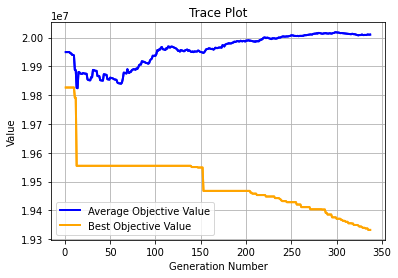

Execution time: 428.84773325920105 s
Evaluation number: 540000
The best objective value is: 19332137.52
The best variables are: 


1	1	0	0	0	1	1	1	0	1	0	0	1	0	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	1	0	1	0	1	1	1	0	0	0	1	1	1	1	0	0	0	1	1	0	0	1	0	1	1	1	1	1	0	1	1	1	1	0	0	0	0	0	1	1	1	0	0	1	0	0	0	0	1	1	1	0	0	1	1	0	1	0	0	1	0	0	1	1	0	1	0	0	1	1	1	0	0	0	1	0	0	0	0	0	1	1	0	1	1	0	0	0	0	0	1	1	0	0	1	1	0	1	0	1	0	1	0	1	1	0	0	1	1	0	1	1	0	0	0	0	0	1	0	1	0	0	0	0	1	0	0	1	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	0	1	1	0	0	0	1	1	0	0	0	1	1	1	0	1	0	0	1	1	0	0	1	0	0	1	0	0	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	0	1	1	1	1	0	0	0	1	1	0	1	0	1	0	0	1	0	0	0	1	0	0	1	0	1	1	0	0	0	0	1	1	0	0	1	0	1	0	0	1	0	1	1	1	0	1	1	0	0	1	0	1	1	0	1	1	0	0	0	0	1	1	0	1	0	1	0	0	1	0	1	1	0	0	1	1	0	0	1	0	0	1	1	1	0	1	1	1	1	0	0	0	1	0	0	0	1	1	0	1	0	1	1	0	0	0	1	0	1	1	0	1	1	0	1	0	1	0	1	1	0	1	1	0	1	0	1	1	1	1	0	1	1	0	0	1	0	0	1	1	0	0	0	1	1	0	0	0	0	1	1	1	1	1	1	1	0	0	0	1	0	1	1	1	1	0	1	0	0	1	1	0	1	0	0	1	1	0	0	0	0	1	0	1	1	0	0	1	1	1	1	1	1	1	1	0	1	1	0	0	0	0	1	1	1	1	0	1	0	0	1	1	1	1	1	1	0	0	0	1	0	0	1	1	1	0	1	0	1	1	1	0	1	0	1	0	0	0	1	1	0	0	0	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	1	1	0	0	0	0	0	1	0	0	0	0	1	1	1	0	1	1	1	0	0	1	0	1	0	

1	0	1	0	0	0	0	0	0	1	0	0	1	0	1	1	0	0	1	1	0	0	0	0	1	0	0	1	1	0	1	1	1	1	0	1	1	0	0	0	0	0	0	1	1	0	1	1	0	1	0	1	1	1	1	0	1	0	1	0	1	1	1	0	0	0	0	0	1	0	0	1	1	0	1	0	0	1	0	1	0	0	0	1	0	0	0	1	1	0	0	0	1	1	0	0	1	1	0	1	0	0	0	1	1	0	0	0	1	0	1	0	1	0	0	1	0	1	0	1	0	0	0	1	0	0	0	0	0	0	1	0	0	0	0	0	0	0	0	0	1	1	0	0	0	1	0	0	1	1	0	1	0	0	1	0	1	1	1	0	1	0	0	0	0	0	0	1	1	0	0	0	0	1	1	0	0	0	1	1	1	1	1	1	0	0	0	0	1	1	0	0	0	1	0	1	1	0	0	1	1	1	1	0	1	1	0	0	1	1	0	0	1	1	0	0	1	1	0	1	1	1	1	1	0	1	0	0	1	1	1	0	0	1	0	1	0	0	1	1	0	1	0	1	1	1	1	0	0	0	1	1	1	1	0	0	0	1	1	1	1	0	0	0	0	0	1	1	1	0	0	0	0	1	1	1	0	1	0	0	1	0	0	0	1	0	1	1	1	1	1	0	1	1	0	1	0	1	0	0	1	1	0	0	0	1	0	1	1	0	1	0	0	0	1	0	0	0	0	1	0	1	1	1	1	1	1	0	1	1	0	1	1	1	1	0	1	1	1	0	1	1	0	0	1	1	1	0	1	1	0	0	1	1	1	1	1	0	1	0	0	1	1	1	1	1	0	0	0	1	0	0	1	0	1	0	0	0	1	1	1	1	0	1	1	1	0	1	0	1	0	0	1	0	0	0	1	0	1	0	0	1	1	1	0	0	0	0	0	1	0	0	1	0	0	1	1	0	0	0	0	0	0	0	1	1	1	0	1	0	0	1	1	0	0	1	1	1	0	0	1	0	0	0	1	0	0	1	1	0	1	0	1	0	0	0	1	1	0	0	1	0	0	1	0	0	1	0	1	1	0	0	0	1	1	1	1	1	0	1	0	1	1	0	1	1	0	1	1	0	0	0	0	1	0	0	1	1	1	1	

1	0	0	0	0	0	1	1	1	0	1	1	1	1	1	1	1	1	0	1	0	0	1	0	0	1	0	0	1	0	1	0	1	0	0	0	0	1	1	1	1	1	1	0	0	0	0	0	0	0	1	0	0	1	0	0	0	1	1	1	0	0	1	1	0	0	1	1	0	0	1	1	0	0	1	0	0	1	0	1	1	0	1	0	1	0	1	0	0	0	1	0	1	1	0	0	0	1	1	1	1	0	0	0	0	0	0	1	1	1	0	1	0	0	0	1	1	1	1	1	0	1	1	1	1	1	1	0	0	0	1	0	1	0	0	0	0	0	1	1	0	0	1	0	1	1	1	0	1	1	1	1	1	1	1	0	0	
{'success': True, 'stopMsg': 'The algotirhm stepped because it exceeded the trapped count limit.', 'optPop': <geatpy.Population.Population object at 0x7fcea4d8ad68>, 'lastPop': <geatpy.Population.Population object at 0x7fcea4d8a2b0>, 'Vars': array([[1, 1, 0, ..., 1, 0, 0]], dtype=int32), 'ObjV': array([[19332137.52]]), 'CV': array([[-2.00000000e-01, -3.45053922e+00, -1.63268382e+00,
        -2.26082548e-03]]), 'executeTime': 428.84773325920105, 'nfev': 540000, 'startTime': '2022-09-27 16h-37m-38s', 'endTime': '2022-09-27 16h-44m-50s'}


In [69]:
# 1000, 1e-6, 300
selectedPackage = DEMO()

`NIND` barely has any influence on the final result, but will slow down the process. -- what about reduce to 100

`maxTrappedCount` has a big influence on the final result. U should try to increase maxTrappedCount to gain better performance.

#### Output

1000 gen = 13 minutes
No early stop if no feasible result is found.


In [53]:
print('Time Consumption: ', np.round(selectedPackage['executeTime'], decimals=2), 's')
print(selectedPackage['stopMsg'])

if selectedPackage['success']:
    print('Algorithm Succeeded!')
    print('===================================================================================================')
    print('Optimal Target Value: ', np.round(selectedPackage['ObjV'].item(), decimals=2))
    print('Constraint Violation: ', np.round(selectedPackage['CV'][0], decimals=2))
    if debug:
        # TODO: doing
        print('===================================================================================================')
        Vars = selectedPackage['Vars'][0]
        print('NBV of standard equip:', np.round((Vars * product @ nbv) / (Vars @ nbv), decimals=2)[0])
        print('Avg age of Manufacturing:', np.round((Vars @ mfrAge) / Vars.sum(), decimals=2)[0])
        print('Avg unexpired term under leases:', np.round((Vars * lesseStatus @ expYear) / (Vars * lesseStatus).sum(), decimals=2)[0])
        print('Top 1 NBV:', np.round((Vars * top1 @ nbv) / (Vars @ nbv), decimals=2)[0])
        print('Top 3 NBV:', np.round((Vars * top3 @ nbv) / (Vars @ nbv), decimals=2)[0])
        
else:
    print('No Feasible Results...')

Time Consumption:  318.33 s
The algotirhm stepped because it exceeded the trapped count limit.
Algorithm Succeeded!
Optimal Target Value:  19458029.26
Constraint Violation:  [-0.2  -3.44 -1.65 -0.  ]
NBV of standard equip: 1.0
Avg age of Manufacturing: 3.56
Avg unexpired term under leases: 6.65
Top 1 NBV: 0.5
Top 3 NBV: 0.98


In [54]:
# print final result
print('Selected Package:')
print('===================================================================================================')
print(len(selectedPackage['Vars'].nonzero()[1]), 'containers selected.')
print(selectedPackage['Vars'].nonzero()[1]) # index begins from 0
print('===================================================================================================')
print(selectedPackage['Vars'][0].tolist())

Selected Package:
4943 containers selected.
[   0    3    4 ... 9992 9996 9999]
[1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0